In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
anime = pd.read_csv(r"C:\Users\Gaurav\OneDrive\Desktop\Anime Recommendation system\anime.csv")
rating = pd.read_csv(r"C:\Users\Gaurav\OneDrive\Desktop\Anime Recommendation system\rating.csv")

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [6]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [7]:
#Lets have a look the distribution of ratings, because those "-1" are suspicious

rating.rating.value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

I'm not sure what the "-1" mean because the ratings goes from 1 up to 10. Maybe it means, that no rating are available. Therefore we will delete the row with "-1" in rating

In [8]:
# I'm not sure what the "-1" mean because the ratings goes from 1 up to 10. 
# Maybe it means, that no rating are available. 
# Therefore we will delete the rows with "-1" in rating

rating = rating[rating["rating"] != -1]

In [9]:
print(f"anime.csv - rows: {anime.shape[0]}, columns: {anime.shape[1]}")
print(f"rating.csv - rows: {rating.shape[0]}, columns: {rating.shape[1]}")

anime.csv - rows: 12294, columns: 7
rating.csv - rows: 6337241, columns: 3


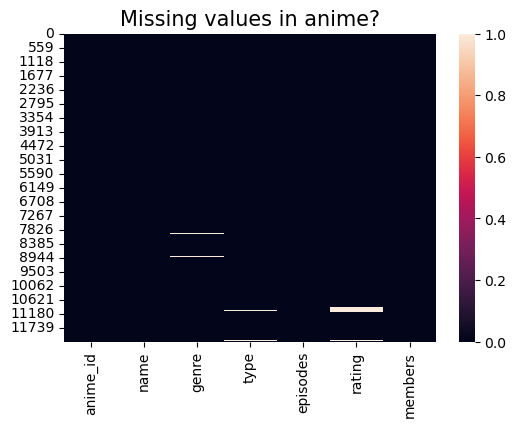

In [11]:
plt.figure(figsize=(6,4))
sns.heatmap(anime.isnull())
plt.title("Missing values in anime?", fontsize = 15)
plt.show()

The anime dataset has some missing values in rating and genre, but we can ignore them, because we won't use those columns later.

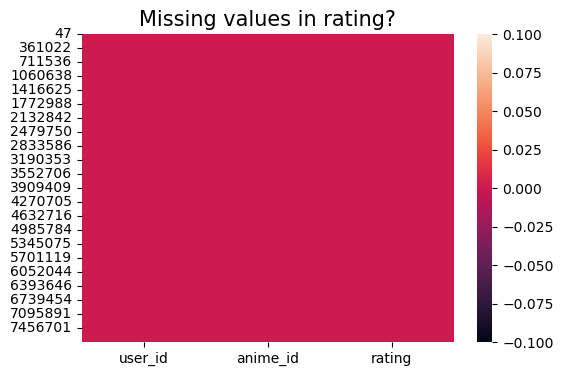

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(rating.isnull())
plt.title("Missing values in rating?", fontsize = 15)
plt.show()

In [15]:
# Merging anime and rating using "anime_id" as reference
# Keeping only the columns we will use

df = pd.merge(rating,anime[["anime_id","name"]], left_on = "anime_id", right_on = "anime_id").drop("anime_id", axis = 1)
df.head()

,user_id,rating,name
0,1,10,Highschool of the Dead
1,3,6,Highschool of the Dead
2,5,2,Highschool of the Dead
3,12,6,Highschool of the Dead
4,14,6,Highschool of the Dead


In [16]:
# Count the number of ratings for each anime
count_rating = df.groupby("name")["rating"].count().sort_values(ascending = False)
count_rating

name
Death Note                         34226
Sword Art Online                   26310
Shingeki no Kyojin                 25290
Code Geass: Hangyaku no Lelouch    24126
Angel Beats!                       23565
                                   ...  
La Primavera                           1
Chou Zenmairobo: Patrasche             1
Ushi Atama                             1
Gun-dou Musashi Recap                  1
Futago no Ookami Daibouken             1
Name: rating, Length: 9926, dtype: int64

In [17]:
# Some animes have only 1 rating, therefore it is better for the recommender system to ignore them
# We will keep only the animes with at least r ratings
r = 5000
more_than_r_ratings = count_rating[count_rating.apply(lambda x: x >= r)].index

# Keep only the animes with at least r ratings in the DataFrame
df_r = df[df['name'].apply(lambda x: x in more_than_r_ratings)]

In [18]:
before = len(df.name.unique())
after = len(df_r.name.unique())
rows_before = df.shape[0]
rows_after = df_r.shape[0]
print(f'''There are {before} animes in the dataset before filtering and {after} animes after the filtering.

{before} animes => {after} animes
{rows_before} rows before filtering => {rows_after} rows after filtering''')

There are 9926 animes in the dataset before filtering and 279 animes after the filtering.

9926 animes => 279 animes
6337239 rows before filtering => 2517097 rows after filtering


In [19]:
# Creating a matrix with userId as rows and the titles of the movies as column.
# Each cell will have the rating given by the user to the animes.
# There will be a lot of NaN values, because each user hasn't watched most of the animes
df_recom = df_r.pivot_table(index='user_id',columns='name',values='rating')
df_recom.iloc[:5,:5]

name,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!
user_id,,,,,
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,7.0,6.0,NaN,NaN,8.0
5,3.0,NaN,NaN,NaN,4.0
7,8.0,NaN,NaN,NaN,NaN


In [20]:
df_r.name.value_counts().head(10)

Death Note                            34226
Sword Art Online                      26310
Shingeki no Kyojin                    25290
Code Geass: Hangyaku no Lelouch       24126
Angel Beats!                          23565
Elfen Lied                            23528
Naruto                                22071
Fullmetal Alchemist: Brotherhood      21494
Fullmetal Alchemist                   21332
Code Geass: Hangyaku no Lelouch R2    21124
Name: name, dtype: int64

In [21]:
def find_corr(df, name):
    '''
    Get the correlation of one anime with the others
    
    Args
        df (DataFrame):  with user_id as rows and movie titles as column and ratings as values
        name (str): Name of the anime
    
    Return
        DataFrame with the correlation of the anime with all others
    '''
    
    similar_to_movie = df.corrwith(df[name])
    similar_to_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    similar_to_movie = similar_to_movie.sort_values(by = 'Correlation', ascending = False)
    return similar_to_movie

In [22]:
# Let's choose an anime
anime1 = 'Naruto'

# Let's try with "Naruto"

# Recommendations
find_corr(df_recom, anime1).head(10)

,Correlation
name,
Naruto,1.000000
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!,0.582344
Naruto: Shippuuden Movie 1,0.578797
Bleach,0.547983
Fairy Tail,0.444271
Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru,0.439225
Dragon Ball Z,0.437442
InuYasha,0.433100
Dragon Ball GT,0.429704


In [23]:
# Not recommended
find_corr(df_recom, anime1).tail(10)

,Correlation
name,
Neon Genesis Evangelion: The End of Evangelion,0.070812
Mahou Shoujo Madoka★Magica,0.070293
Paprika,0.065754
Cowboy Bebop,0.064961
NHK ni Youkoso!,0.063474
Ghost in the Shell,0.053962
FLCL,0.046725
Mushishi,0.037165
Baccano!,0.033748


In [24]:
# Let's choose an anime
anime2 = 'Death Note'

# Recommendations
find_corr(df_recom, anime2).head(10)

,Correlation
name,
Death Note,1.000000
Code Geass: Hangyaku no Lelouch R2,0.358927
Code Geass: Hangyaku no Lelouch,0.351290
Shingeki no Kyojin,0.346770
Naruto,0.313676
Final Fantasy VII: Advent Children,0.305436
Bleach,0.301795
Elfen Lied,0.297404
Dragon Ball Z,0.296798


In [25]:
# Not recommended
find_corr(df_recom, anime2).tail(10)

,Correlation
name,
NHK ni Youkoso!,0.126408
Shinsekai yori,0.118927
Neon Genesis Evangelion,0.108453
Neon Genesis Evangelion: The End of Evangelion,0.104087
Mushishi,0.103755
Paprika,0.097125
Ghost in the Shell,0.088121
Cowboy Bebop,0.074552
FLCL,0.062253


In [29]:
# Let's choose an anime
anime3 = 'One Punch Man'

# Recommendations
find_corr(df_recom, anime2).head(10)

,Correlation
name,
One Punch Man,1.000000
Shokugeki no Souma,0.418732
Overlord,0.388824
Noragami Aragoto,0.376252
Fate/stay night: Unlimited Blade Works 2nd Season,0.359017
Nanatsu no Taizai,0.357597
Blood Lad,0.354749
Boku dake ga Inai Machi,0.353142
No Game No Life,0.353036


In [30]:
# Not recommended
find_corr(df_recom, anime3).tail(10)

,Correlation
name,
Cardcaptor Sakura,0.128793
Fullmetal Alchemist,0.128600
Ghost in the Shell,0.128005
Bishoujo Senshi Sailor Moon,0.123783
School Days,0.120645
Cowboy Bebop,0.116958
Neon Genesis Evangelion: The End of Evangelion,0.100809
Neon Genesis Evangelion,0.071958
Nana,0.062668
